In [8]:
import numpy as np
import cv2 as cv
import glob



################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (7,6)



# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

In [9]:
# imagesLeft = glob.glob('.\calibration_images\*L.png')
# imagesRight = glob.glob('.\calibration_images\*R.png')
imagesLeft = glob.glob('./imgs/left/*.png')
imagesRight = glob.glob('./imgs/right/*.png')

In [10]:
# img = cv.imread(imagesRight[1])
# gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# ret, corners = cv.findChessboardCorners(gray, (7, 6), None)

# ret

In [11]:
# import matplotlib.pyplot as plt

# plt.imshow(img)

In [12]:
for imgLeft, imgRight in zip(imagesLeft, imagesRight):

    imgL = cv.imread(imgLeft)
    imgR = cv.imread(imgRight)
    grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv.findChessboardCorners(grayL, chessboardSize, None)
    retR, cornersR = cv.findChessboardCorners(grayR, chessboardSize, None)

    # If found, add object points, image points (after refining them)
    if retL and retR == True:

        objpoints.append(objp)

        cornersL = cv.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)

        cornersR = cv.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        cv.drawChessboardCorners(imgL, chessboardSize, cornersL, retL)
        cv.imshow('img left', imgL)
        cv.drawChessboardCorners(imgR, chessboardSize, cornersR, retR)
        cv.imshow('img right', imgR)
        cv.waitKey(1000)


cv.destroyAllWindows()

In [13]:
frameSize = grayL.shape[::-1]

In [14]:
############## CALIBRATION #######################################################

retL, cameraMatrixL, distL, rvecsL, tvecsL = cv.calibrateCamera(objpoints, imgpointsL, frameSize, None, None)
heightL, widthL, channelsL = imgL.shape
newCameraMatrixL, roi_L = cv.getOptimalNewCameraMatrix(cameraMatrixL, distL, (widthL, heightL), 1, (widthL, heightL))

retR, cameraMatrixR, distR, rvecsR, tvecsR = cv.calibrateCamera(objpoints, imgpointsR, frameSize, None, None)
heightR, widthR, channelsR = imgR.shape
newCameraMatrixR, roi_R = cv.getOptimalNewCameraMatrix(cameraMatrixR, distR, (widthR, heightR), 1, (widthR, heightR))

In [15]:
########## Stereo Vision Calibration #############################################

flags = 0
flags |= cv.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, rot, trans, essentialMatrix, fundamentalMatrix = cv.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], criteria_stereo, flags)

#print(newCameraMatrixL)
#print(newCameraMatrixR)

########## Stereo Rectification #################################################

In [16]:
########## Stereo Rectification #################################################

rectifyScale= 0
rectL, rectR, projMatrixL, projMatrixR, Q, roi_L, roi_R= cv.stereoRectify(newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], rot, trans, rectifyScale,(0,0))

stereoMapL = cv.initUndistortRectifyMap(newCameraMatrixL, distL, rectL, projMatrixL, grayL.shape[::-1], cv.CV_32FC1)
stereoMapR = cv.initUndistortRectifyMap(newCameraMatrixR, distR, rectR, projMatrixR, grayR.shape[::-1], cv.CV_32FC1)

print("Saving parameters!")
cv_file = cv.FileStorage('stereoMap.xml', cv.FILE_STORAGE_WRITE)

cv_file.write('point_projection', Q)
cv_file.write('stereoMapL_x',stereoMapL[0])
cv_file.write('stereoMapL_y',stereoMapL[1])
cv_file.write('stereoMapR_x',stereoMapR[0])
cv_file.write('stereoMapR_y',stereoMapR[1])

cv_file.release()

Saving parameters!


In [17]:
print(Q)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -6.97444145e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -6.60152470e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.70727496e+03]
 [ 0.00000000e+00  0.00000000e+00  6.14691285e-01 -0.00000000e+00]]


In [18]:
# Camera parameters to undistort and rectify images
cv_file = cv.FileStorage()
cv_file.open('stereoMap.xml', cv.FileStorage_READ)

Q = cv_file.getNode("point_projection").mat()
stereoMapL_x = cv_file.getNode('stereoMapL_x').mat()
stereoMapL_y = cv_file.getNode('stereoMapL_y').mat()
stereoMapR_x = cv_file.getNode('stereoMapR_x').mat()
stereoMapR_y = cv_file.getNode('stereoMapR_y').mat()

In [19]:
stereoMapL_x.shape

(1080, 1920)

In [20]:
def undistortRectify(frameR, frameL):

    # Undistort and rectify images
    undistortedL= cv.remap(frameL, stereoMapL_x, stereoMapL_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)
    undistortedR= cv.remap(frameR, stereoMapR_x, stereoMapR_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)


    return undistortedR, undistortedL

In [196]:
import sys
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt

# Open both cameras
imgL = cv2.imread(imagesLeft[5])
imgR = cv2.imread(imagesRight[5])
# imgL = cv2.imread("E:\stereo-vision\Digesting-Depth-Data-Intel-Realsense-main\Digesting-Depth-Data-Intel-Realsense-main\scripts\samples\left\\000000.png")
# imgR = cv2.imread("E:\stereo-vision\Digesting-Depth-Data-Intel-Realsense-main\Digesting-Depth-Data-Intel-Realsense-main\scripts\samples\\right\\000000.png")



# Stereo vision setup parameters
frame_rate = 90    #Camera frame rate (maximum at 120 fps)
B = 50               #Distance between the cameras [mm]
f = 8              #Camera lense's focal length [mm]
alpha = 87       #Camera field of view in the horisontal plane [degrees]

In [197]:
frame_right, frame_left = undistortRectify(imgR, imgL)

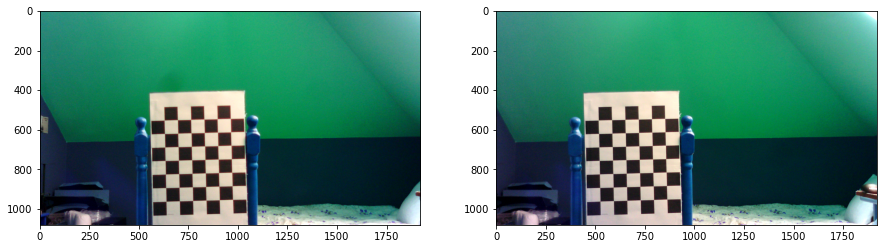

In [198]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(frame_left)
plt.subplot(1, 2, 2)
plt.imshow(frame_right)

In [199]:
def find_depth(right_point, left_point, frame_right, frame_left, baseline,f, alpha):

    # CONVERT FOCAL LENGTH f FROM [mm] TO [pixel]:
    height_right, width_right = frame_right.shape
    height_left, width_left = frame_left.shape

    if width_right == width_left:
        f_pixel = (width_right * 0.5) / np.tan(alpha * 0.5 * np.pi/180)

    else:
        print('Left and right camera frames do not have the same pixel width')

    x_right = right_point[0]
    x_left = left_point[0]

    # CALCULATE THE DISPARITY:
    disparity = x_left-x_right      #Displacement between left and right frames [pixels]

    # CALCULATE DEPTH z:
    zDepth = (baseline*f_pixel)/disparity             #Depth in [cm]

    return zDepth

In [206]:
# disparity range is tuned for 'aloe' image pair
window_size = 6
min_disp = 16
num_disp = 112-min_disp
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 16,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32
)

In [207]:
disparity = stereo.compute(frame_left, frame_right)

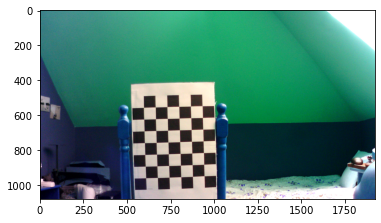

In [208]:
plt.imshow(imgR)

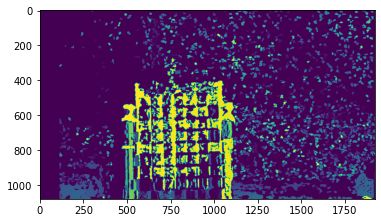

In [209]:
plt.imshow(disparity)

In [212]:
depth = (B * f) / (disparity + 1e-10)
depth[depth > 10000] = 10000

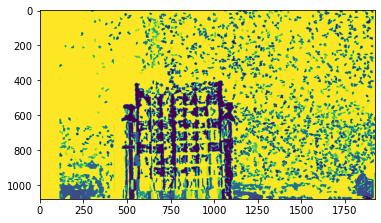

In [213]:
plt.imshow(depth)

In [214]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

In [215]:
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [216]:
points = cv.reprojectImageTo3D(disparity, Q)
colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
mask = disparity > disparity.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)

out.ply saved


In [217]:
# Package importation
import numpy as np
import cv2
import glob
from openpyxl import Workbook # Used for writing data into an Excel file
from sklearn.preprocessing import normalize

# Filtering
kernel= np.ones((3,3),np.uint8)
        
# This section has to be uncommented if you want to take mesurements and store them in the excel
##        ws.append([counterdist, average])
##        print('Measure at '+str(counterdist)+' cm, the dispasrity is ' + str(average))
##        if (counterdist <= 85):
##            counterdist += 3
##        elif(counterdist <= 120):
##            counterdist += 5
##        else:
##            counterdist += 10
##        print('Next distance to measure: '+str(counterdist)+'cm')

# Mouseclick callback
wb=Workbook()
ws=wb.active  
# 1313.7562366357804
#*************************************************
#***** Parameters for Distortion Calibration *****
#*************************************************

# Termination criteria
criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all images
objpoints= []   # 3d points in real world space
imgpointsR= []   # 2d points in image plane
imgpointsL= []


imagesLeft = glob.glob('.\calibration_images\*L.png')
imagesRight = glob.glob('.\calibration_images\*R.png')
# Start calibration from the camera
print('Starting calibration for the 2 cameras... ')
# Call all saved images
for i in range(0,len(imagesLeft)):   # Put the amount of pictures you have taken for the calibration inbetween range(0,?) wenn starting from the image number 0
    ChessImaR= cv2.imread(imagesLeft[i],0)    # Right side
    ChessImaL= cv2.imread(imagesRight[i],0)    # Left side
    retR, cornersR = cv2.findChessboardCorners(ChessImaR,
                                               (9,6),None)  # Define the number of chees corners we are looking for
    retL, cornersL = cv2.findChessboardCorners(ChessImaL,
                                               (9,6),None)  # Left side
    if (True == retR) & (True == retL):
        objpoints.append(objp)
        cv2.cornerSubPix(ChessImaR,cornersR,(11,11),(-1,-1),criteria)
        cv2.cornerSubPix(ChessImaL,cornersL,(11,11),(-1,-1),criteria)
        imgpointsR.append(cornersR)
        imgpointsL.append(cornersL)

# Determine the new values for different parameters
#   Right Side
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints,
                                                        imgpointsR,
                                                        ChessImaR.shape[::-1],None,None)
hR,wR= ChessImaR.shape[:2]
OmtxR, roiR= cv2.getOptimalNewCameraMatrix(mtxR,distR,
                                                   (wR,hR),1,(wR,hR))

#   Left Side
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints,
                                                        imgpointsL,
                                                        ChessImaL.shape[::-1],None,None)
hL,wL= ChessImaL.shape[:2]
OmtxL, roiL= cv2.getOptimalNewCameraMatrix(mtxL,distL,(wL,hL),1,(wL,hL))

print('Cameras Ready to use')

#********************************************
#***** Calibrate the Cameras for Stereo *****
#********************************************

# StereoCalibrate function
#flags = 0
#flags |= cv2.CALIB_FIX_INTRINSIC
#flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
#flags |= cv2.CALIB_USE_INTRINSIC_GUESS
#flags |= cv2.CALIB_FIX_FOCAL_LENGTH
#flags |= cv2.CALIB_FIX_ASPECT_RATIO
#flags |= cv2.CALIB_ZERO_TANGENT_DIST
#flags |= cv2.CALIB_RATIONAL_MODEL
#flags |= cv2.CALIB_SAME_FOCAL_LENGTH
#flags |= cv2.CALIB_FIX_K3
#flags |= cv2.CALIB_FIX_K4
#flags |= cv2.CALIB_FIX_K5
retS, MLS, dLS, MRS, dRS, R, T, E, F= cv2.stereoCalibrate(objpoints,
                                                          imgpointsL,
                                                          imgpointsR,
                                                          mtxL,
                                                          distL,
                                                          mtxR,
                                                          distR,
                                                          ChessImaR.shape[::-1],
                                                          criteria = criteria_stereo,
                                                          flags = cv2.CALIB_FIX_INTRINSIC)

# StereoRectify function
rectify_scale= 0 # if 0 image croped, if 1 image nor croped
RL, RR, PL, PR, Q, roiL, roiR= cv2.stereoRectify(MLS, dLS, MRS, dRS,
                                                 ChessImaR.shape[::-1], R, T,
                                                 rectify_scale,(0,0))  # last paramater is alpha, if 0= croped, if 1= not croped
# initUndistortRectifyMap function
Left_Stereo_Map= cv2.initUndistortRectifyMap(MLS, dLS, RL, PL,
                                             ChessImaR.shape[::-1], cv2.CV_16SC2)   # cv2.CV_16SC2 this format enables us the programme to work faster
Right_Stereo_Map= cv2.initUndistortRectifyMap(MRS, dRS, RR, PR,
                                              ChessImaR.shape[::-1], cv2.CV_16SC2)




Starting calibration for the 2 cameras... 
Cameras Ready to use
Saving parameters!


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'write'
> Overload resolution failed:
>  - Argument 'val' is required to be an integer
>  - Argument 'val' can not be treated as a double
>  - Can't convert object to 'str' for 'val'
>  - val is not a numerical tuple
>  - Can't parse 'val'. Sequence item with index 0 has a wrong type


In [223]:
print("Saving parameters!")
cv_file = cv2.FileStorage('stereoMap.xml', cv2.FILE_STORAGE_WRITE)

cv_file.write("Q", Q)
cv_file.write('leftStereoMap0', Left_Stereo_Map[0])
cv_file.write('leftStereoMap1', Left_Stereo_Map[1])
cv_file.write('rightStereoMap0', Right_Stereo_Map[0])
cv_file.write('rightStereoMap1', Right_Stereo_Map[1])

cv_file.release()

Saving parameters!


In [221]:
Left_Stereo_Map[0].shape

(480, 640, 2)

In [224]:
Q.shape

(4, 4)